In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [2]:
PATH = "data"
AUTOTUNE = tf.data.experimental.AUTOTUNE
WIDTH, HEIGHT = 128, 128
BATCH_SIZE = 4

def load_data(path):
    images = sorted(glob(f"{path}/images/*.png"))
    masks = sorted(glob(f"{path}/masks/*.png"))
    return images, masks

In [3]:
image_files, mask_files = load_data(PATH)

In [4]:
print(len(image_files), len(mask_files))
DATASET_SIZE = len(image_files)

2667 2667


In [5]:
print(image_files[0], mask_files[0])
#print(images)

data/images/ds10_pexels-photo-687782.png data/masks/ds10_pexels-photo-687782.png


data/images/ds10_pexels-photo-687782.png
<class 'numpy.ndarray'>
[[[0.02352941 0.09803922 0.2627451 ]
  [0.02352941 0.09803922 0.26666668]
  [0.02352941 0.09803922 0.2627451 ]
  ...
  [0.         0.21568628 0.4392157 ]
  [0.00392157 0.21960784 0.44313726]
  [0.         0.21568628 0.4392157 ]]

 [[0.01176471 0.09411765 0.27058825]
  [0.01176471 0.09411765 0.2784314 ]
  [0.02352941 0.09803922 0.2627451 ]
  ...
  [0.         0.22352941 0.4392157 ]
  [0.         0.21568628 0.43529412]
  [0.00392157 0.22745098 0.44313726]]

 [[0.02352941 0.09803922 0.2627451 ]
  [0.02352941 0.09803922 0.26666668]
  [0.02352941 0.09803922 0.2627451 ]
  ...
  [0.00392157 0.21960784 0.4392157 ]
  [0.         0.21568628 0.4392157 ]
  [0.         0.21960784 0.44313726]]

 ...

 [[0.04705882 0.10196079 0.10588235]
  [0.04705882 0.10196079 0.10588235]
  [0.04705882 0.10196079 0.10588235]
  ...
  [0.04705882 0.10196079 0.10588235]
  [0.04705882 0.10196079 0.10588235]
  [0.04705882 0.10196079 0.10588235]]

 [[0.0470

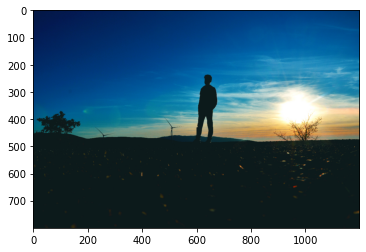

In [6]:
print(image_files[0])
img = tf.keras.preprocessing.image.load_img(image_files[0])
img_arr = tf.keras.preprocessing.image.img_to_array(img)
print(type(img_arr))
#print(img_arr)
img_arr = img_arr/255.0
print(img_arr)
plt.imshow(img_arr)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))


In [ ]:
print(dataset)

In [ ]:
def normalize(input_image, input_mask):
    #input_image = tf.cast(input_image, tf.float32)/ 255.0
    input_image = input_image/255.0
    input_mask -= 1
    
    return input_image, input_mask


def read_image(image_file, mask_file):
    
    #img = tf.keras.preprocessing.image.load_img(image_file, target_size=(HEIGHT, WIDTH))
    #img_arr = tf.keras.preprocessing.image.img_to_array(img)
    
    #mask_img = tf.keras.preprocessing.image.load_img(mask_file, target_size=(HEIGHT, WIDTH))
    #mask_img_arr = tf.keras.preprocessing.image.img_to_array(mask_img)
    
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=3, dtype=tf.uint16)
    img = tf.image.resize(img, size=(WIDTH, HEIGHT))
    msk = tf.io.read_file(mask_file)
    msk = tf.image.decode_png(msk, channels=1, dtype=tf.uint16)
    msk = tf.image.resize(msk, size=(WIDTH, HEIGHT))
    
    img, msk = normalize(img, msk)
    
    return img, msk


#def read_image(image_file, mask_file):
    #print(image_file, mask_file)
#    img = tf.io.read_file(image_file)
#    img = tf.image.decode_png(img, channels=3, dtype=tf.uint16)
#    img = tf.image.resize(img, size=(WIDTH, HEIGHT))
#    msk = tf.io.read_file(mask_file)
#    msk = tf.image.decode_png(msk, channels=1, dtype=tf.uint16)
#    msk = tf.image.resize(msk, size=(WIDTH, HEIGHT))
    
#    img, msk = normalize(img, msk)
    
#    return img, msk

In [ ]:
dataset = dataset.map(read_image).batch(BATCH_SIZE)


In [ ]:
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(dataset)

In [ ]:
def display(display_list):
    plt.figure(figsize=(128,128))
    print(display_list)
    title = ['input image', 'true mask', 'predicted mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
for image, mask in dataset.take(2):
    sample_image, sample_mask = image, mask
#display([sample_image[0], sample_mask[0]])
display([sample_image[0], sample_mask[0]])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [ ]:
base_model.summary()

In [ ]:
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'    
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [ ]:
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [ ]:
down_stack.summary()

In [ ]:
down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [ ]:
def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    skips = down_stack(inputs)
    #print(skips)

    x = skips[-1]
    #print(x)

    skips = reversed(skips[:-1])
    print(skips)

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding='same')

    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)




In [ ]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=2):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(dataset)

In [ ]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

print(train_size, val_size, test_size)

In [ ]:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
validation_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

In [ ]:
print(train_ds, test_ds, validation_ds)

In [ ]:
print(train_ds.cardinality)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(dataset)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
print(train_ds)

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = train_size//BATCH_SIZE

#model_history = model.fit(train_ds, epochs=EPOCHS,
#                          steps_per_epoch=STEPS_PER_EPOCH,
#                          validation_steps=VALIDATION_STEPS,
#                          validation_data=test_ds,
#                          callbacks=[DisplayCallback()])

model_history = model.fit(train_ds, epochs=EPOCHS,
                          validation_data=test_ds,
                          callbacks=[DisplayCallback()])